# Statistical Analysis of Data

## Environment Settings

An statistical Analysis of the data captured will be performed.

The environment configuration is the following:

- A rectangle area is used whose dimension is 2 x 1.5 meters. 
- A custom robot similar to an epuck was used.
- The robot starts in the middle of the arena.
- The robot moves in a random fashion way around the environment avoiding obstacles for 100 robot steps then it is moved into another random location.
- The data is not normalized in this experiment.
- The robot has 8 sensors that measure the distance between the robot and the walls.
- Some noise was introduced in the sensors measurements of the robot using the concept of [lookup tables](https://cyberbotics.com/doc/reference/distancesensor) in the Webots simulator which according to Webots documentation "The first column of the table specifies the input distances, the second column specifies the corresponding desired response values, and the third column indicates the desired standard deviation of the noise. The noise on the return value is computed according to a gaussian random number distribution whose range is calculated as a percent of the response value (two times the standard deviation is often referred to as the signal quality)". The following values were taken:

        - (0, 0, 0.05)
        - (10, 10, 0.05)
        
- The simulator runs during 10 hours of simulation (~10 minutes in fast mode).

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install keras

import pandas as pd
import tensorflow as tf
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from keras import models
from keras import layers
from keras import regularizers
import matplotlib.pyplot as plt
from keras import optimizers

Using TensorFlow backend.


# First Experiment

In [2]:
csv_file = 'robot_info_dataset.csv'
df = pd.read_csv(csv_file)
df.head()

,Unnamed: 0,x,y,theta,dx,dy,dtheta,sensor_1,sensor_2,sensor_3,...,sensor_7,sensor_8,dsensor_1,dsensor_2,dsensor_3,dsensor_4,dsensor_5,dsensor_6,dsensor_7,dsensor_8
0,0,1.050733,1.094226,308.240738,0.059450,0.344226,128.240516,1.061660,1.289745,0.990510,...,1.000384,1.083896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.052836,1.093243,311.136141,0.002103,-0.000982,2.895403,1.129972,1.214009,1.135844,...,0.993033,1.009313,0.068312,-0.075736,0.145334,0.327937,0.133375,0.140812,-0.007352,-0.074582
2,2,1.054507,1.091473,315.074322,0.001672,-0.001770,3.938181,1.185616,1.131318,1.019394,...,0.956272,0.944564,0.055645,-0.082692,-0.116450,0.110155,0.029906,-0.014191,-0.036761,-0.064750
3,3,1.056316,1.089796,319.070072,0.001809,-0.001677,3.995750,1.098113,1.103999,1.094631,...,0.881076,1.000029,-0.087503,-0.027318,0.075237,0.054568,-0.004316,-0.045687,-0.075196,0.055465
4,4,1.058129,1.088026,323.456321,0.001812,-0.001770,4.386249,1.327904,1.104746,1.123384,...,0.842176,0.892464,0.229791,0.000746,0.028753,-0.037511,0.034774,-0.001614,-0.038900,-0.107565


## Data pre-processing

The data collected 1384848 samples.

In [3]:
df.shape

(1125965, 23)

The data set contains some null values so they should be deleted from the samples.

In [4]:
df = df.dropna()

## Input and output variables

The data will be split into training, testing and validation sets. 60% of the data will be used for training, 20% for training and 20% of validation.

In [5]:

# train size
test_size_percentage = .2
train_size_percentage = .8
ds_size = df.shape[0]
train_size = int(train_size_percentage * ds_size)
test_size = int(test_size_percentage * ds_size)

# shuffle dataset
sampled_df = df.sample(frac=1)

# separate inputs from outputs
inputs = sampled_df[['x', 'y', 'theta']]
targets = sampled_df[['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8']]

# train
train_inputs = inputs[:train_size]
train_targets = targets[:train_size]

# test
test_inputs = inputs[train_size:]
test_targets = targets[train_size:]

## Neural Network


As input the neural network receives the x, y coordinates and rotation angle $\theta$. The output are the sensor measurements. One model per sensor will be created.

In [6]:

def get_model():
    # neural network with a 10-neuron hidden layer
    model = models.Sequential()
    model.add(layers.Dense(10, activation='relu', input_shape=(3,)))
#     model.add(layers.Dropout(0.5))
    model.add(layers.Dense(6, activation='relu'))
    model.add(layers.Dense(3, activation='relu'))
    model.add(layers.Dense(1))
    
#     rmsprop = optimizers.RMSprop(learning_rate=0.01)
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
              
    return model

In [7]:
train_targets[['sensor_1']][0:10]

,sensor_1
1003687,0.237808
924742,0.792122
680393,0.556707
1120943,1.269383
799006,0.740939
401289,0.645360
987004,1.070987
945838,1.305558
62311,1.315325
519383,0.918046


In [8]:
def k_fold(sensor_number, num_epochs=10, k=5):
    num_val_samples = len(train_inputs) // k
    validation_scores = []
    histories = []
    nmse = []

    for i in range(k):
        print('processing fold #', i)
        val_data = train_inputs[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[[sensor_number]][i * num_val_samples: (i + 1) * num_val_samples]

        partial_train_data = np.concatenate(
            [train_inputs[:i * num_val_samples],
             train_inputs[(i + 1) * num_val_samples:]], axis=0)
        partial_train_targets = np.concatenate(
            [train_targets[[sensor_number]][:i * num_val_samples],
             train_targets[[sensor_number]][(i + 1) * num_val_samples:]], axis=0)


        model = get_model()

        history = model.fit(partial_train_data, partial_train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=1, verbose=1)
        histories.append(history.history)

        predictions_targets = model.predict(val_data)
        nmse.append(np.mean((predictions_targets - val_targets)**2)/np.var(val_targets))
        
    return histories, nmse


In [9]:
histories, nmse = k_fold('sensor_1', 150, 3)

processing fold # 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 600514 samples, validate on 300257 samples
Epoch 1/150
  7465/600514 [..............................] - ETA: 12:08 - loss: 15.7399 - mae: 0.8689

KeyboardInterrupt: 

NMSE: 
0.27307531306958077


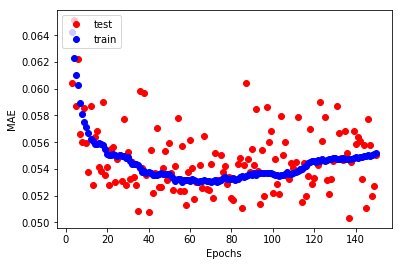

In [60]:
print("NMSE: ")
print(np.mean(nmse))

num_epochs = 150
val_mae_history = [np.mean([x['val_mae'][i] for x in histories]) for i in range(num_epochs)]
mae_history = [np.mean([x['mae'][i] for x in histories]) for i in range(num_epochs)]
plt.plot(range(3, len(val_mae_history) + 1), val_mae_history[2:], 'ro')
plt.plot(range(3, len(mae_history) + 1), mae_history[2:], 'bo')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['test', 'train'], loc='upper left')
plt.show()


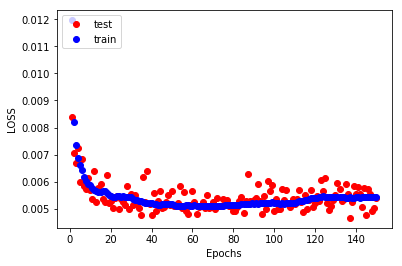

In [61]:
val_loss_history = [np.mean([x['val_loss'][i] for x in histories]) for i in range(num_epochs)]
loss_history = [np.mean([x['loss'][i] for x in histories]) for i in range(num_epochs)]
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, 'ro')
plt.plot(range(1, len(loss_history) + 1), loss_history, 'bo')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend(['test', 'train'], loc='upper left')
plt.show()

In [11]:
model = get_model()

history = model.fit(inputs, targets[['sensor_6']], epochs=34, batch_size=1, verbose=1)
history.history['mae']
model.save("nn_sensor_6.h5")

Epoch 1/34
1125964/1125964 [==============================] - 1904s 2ms/step - loss: 0.2298 - mae: 0.4033
Epoch 2/34
1125964/1125964 [==============================] - 2013s 2ms/step - loss: 0.2296 - mae: 0.4032
Epoch 3/34
1125964/1125964 [==============================] - 2236s 2ms/step - loss: 0.2296 - mae: 0.4032
Epoch 4/34
1125964/1125964 [==============================] - 2258s 2ms/step - loss: 0.2296 - mae: 0.4032
Epoch 5/34
1125964/1125964 [==============================] - 1981s 2ms/step - loss: 0.2296 - mae: 0.4032
Epoch 6/34
1125964/1125964 [==============================] - 1903s 2ms/step - loss: 0.2296 - mae: 0.4032
Epoch 7/34
1125964/1125964 [==============================] - 1953s 2ms/step - loss: 0.2296 - mae: 0.4031
Epoch 8/34
1125964/1125964 [==============================] - 1949s 2ms/step - loss: 0.2296 - mae: 0.4032
Epoch 9/34
1125964/1125964 [==============================] - ETA: 0s - loss: 0.2296 - mae: 0.403 - 1955s 2ms/step - loss: 0.2296 - mae: 0.4032
Epoch 10